# CSE 5526 PA2 Utkarsh Pratap Singh Jadon

## Question 1

### Import necessary libraries

In [1]:
import random
import math
from datetime import datetime
random.seed(datetime.now())
import matplotlib.pyplot as plt

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_2398/163788001.py:4: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(datetime.now())


### Create necessary functions

In [2]:
def getDistanceSquared(x, y):
    # Assume x and y are both 1-d
    return (x - y)**2

class Gaussian:
    
    def __init__(self, center):
        self.variance = 0.5
        self.center = center
        
    def getGaussianValue(self, x):
        return math.exp(-0.5 / self.variance * getDistanceSquared(x, self.center))

class Cluster(Gaussian):

    member_list = list()

    def clearMember(self):
        self.member_list = list()

    def hasMoreThanOne(self):
        return len(self.member_list) > 1

    def updateCenter(self):
        if len(self.member_list) > 0:
            new_center = sum(self.member_list) / len(self.member_list)
            
            if new_center == self.center:
                is_converged = True
            else:
                is_converged = False
                self.member_list = list()
            self.center = new_center
            return is_converged
        else:
            return True

    def updateVariance(self, avg_variance=0.5):
        if len(self.member_list) <= 1:
            self.variance = avg_variance
        else:
            s = 0.0
            for x in self.member_list:
                s += getDistanceSquared(x, self.center)
            self.variance = s / float(len(self.member_list))

    def getDistanceToCenter(self, x):
        return getDistanceSquared(x, self.center)

    def printInfo(self):
        pass

def getClusters(sample_x_list, k):

    cluster_list = list()
    
    # Initial cluster centers are chosen randomly
    
    init_center_list = random.sample(sample_x_list, k)
    for x in range(k):
        new_cluster = Cluster(init_center_list[x])
        cluster_list.append(new_cluster)
       
    clusters_converged = False
        
    while not clusters_converged:
        for i in range(len(sample_x_list)):
            
            # Finds the closest cluster center for each sample
            cluster_distance_list = list()
            current_x = sample_x_list[i]

            # Pushes the distance to each cluster into cluster_distance_list
            for c in cluster_list:
                distance_to_c = c.getDistanceToCenter(current_x)
                cluster_distance_list.append(distance_to_c)

            # Gets the index of the closest cluster
            closest_cluster_index = cluster_distance_list.index(min(cluster_distance_list))
            cluster_list[closest_cluster_index].member_list.append(current_x)
        
        # Verifies if all clusters have converged
        clusters_converged = True
        for c in cluster_list:
            clusters_converged = clusters_converged and c.updateCenter()
        
        if not clusters_converged:
            for c in cluster_list:
                c.clearMember()
            
    return cluster_list
    
def updateClustersVariances(clusters, k, mode=0):
    # Sets the clusters' variances after they are finalized

    cluster_list = list()
    cluster_list[:] = clusters[:]
    if mode == 0:
        # Regular variance update
        # If a cluster has only 1 member    
        num_legit_clusters = k
        
        sum_variances = 0.0
        for c in cluster_list:
            if c.hasMoreThanOne:
                c.updateVariance()
                sum_variances += c.variance
            else:
                num_legit_clusters -= 1
        print
        mean_variance = sum_variances / num_legit_clusters
        for c in cluster_list:
            if not c.hasMoreThanOne:
                c.updataVariance(mean_variance)
        
    else:
        # Simplified varaince update using universal variance for all clusters
        # variance = d_max^2 / 2K
        
        center_distance_list = list()
        for ci in cluster_list:
            for cj in cluster_list:
                center_distance_list.append(getDistanceSquared(ci.center, cj.center))
        d_max_squared = max(center_distance_list)
        print
        max_variance = d_max_squared / (2.0 * k)
        for c in cluster_list:
            c.variance = max_variance

    return cluster_list

In [3]:
def sigmoid(x):
    return 1.0 / (1.0 + math.exp(-x))

class RBF:

    gaussian_list = list()
    weight_list = list()
    b = 0.0

    def __init__(self, k):
        # Initializes the weights and the bias with random numbers
        for i in range(k):
            self.weight_list.append(random.uniform(0.0, 0.5))
            self.b = random.uniform(0.0, 0.5)

    def getY(self, x):
        # Outputs the y from the final output neuron
        y = 0.0
        for i in range(len(self.gaussian_list)):
            y += self.gaussian_list[i].getGaussianValue(x) * self.weight_list[i]
        y += self.b
        return y

    def updatePhi(self, clusters):
        # Assigns the determined gaussian clusters to the network
        self.gaussian_list[:] = clusters[:]

    def updateNetwork(self, sample_list, k, eta, num_epoch = 100):
        
        for epoch in range(num_epoch):
            # In each epoch, we update the weights and the bias by each sample

            for sample in sample_list:
                current_x = sample[0]
                current_d = sample[1]
                e = current_d - self.getY(current_x)
                for j in range(k):
                    # The inputs of the output neuron come from the outputs of the phi's
                    current_phi_x = self.gaussian_list[j].getGaussianValue(current_x) 
                    self.weight_list[j] += eta * e * current_phi_x
                self.b += eta * e

In [4]:
sample_list = list()
sample_x_list = list()
sample_y_list = list()
sample_d_list = list()

def getH(x):    
    h = 0.5 + 0.4 * math.sin(2.0 * math.pi * x)
    return h

def getNoisedH(x):
    noise = random.uniform(-0.1, 0.1)
    h = getH(x) + noise
    return h

def getSamples(data_x,num=75):
    global sample_list 
    global sample_x_list 
    global sample_y_list
    global sample_d_list
    
    sample_list = list()
    sample_x_list = list()
    sample_y_list = list()
    sample_d_list = list()

    for x in data_x:
        h_x = getNoisedH(x)
        d = getH(x)

        sample_x_list.append(x)
        sample_y_list.append(h_x)
        sample_d_list.append(d)
        sample_list.append( (x, d) )


def run(x,K,ETA,MODE,NUM_SAMPLES,NUM_EPOCHES):

    getSamples(x,NUM_SAMPLES)

    cluster_list = list()
    init_cluster_list = getClusters(sample_x_list, K)
    final_cluster_list = updateClustersVariances(init_cluster_list, K, MODE)

    learner = RBF(K)
    learner.updatePhi(final_cluster_list)
    learner.updateNetwork(sample_list, K, ETA, NUM_EPOCHES)

    learned_y_list = list()
    for x in sample_x_list:
        learned_y_list.append(learner.getY(x))

    fig= plt.figure()
    plt.xlabel('X')
    plt.ylabel('H(X)')
    plt.axis([0.0, 1.0, 0.0, 1.0])
    original, = plt.plot(sample_x_list, sample_y_list, 'ro', label='Original')

    # Sorts the RBF dots in the order by x-axis so that we can plot a regression line through sampled points
    combined_rbf = list(zip(sample_x_list, learned_y_list))
    sorted_combined_rbf = sorted(combined_rbf, key = lambda x: x[0])
    rbf_function_unzipped = list(zip(*sorted_combined_rbf))

    rbf_function, = plt.plot(rbf_function_unzipped[0], rbf_function_unzipped[1], 'bx-', label='RBF')
    legends = plt.legend([original, rbf_function], ['Original', 'RBF'])
    
    plot_file_name = "plot_base" + str(K) + "eta" + str(ETA) + "mode" + str(MODE) + "epoch" + str(NUM_EPOCHES) + "sample" + str(NUM_SAMPLES) + ".png"
    plot_title = "Base:" + str(K) + ", Eta:" + str(ETA) + ", Mode:" + str(MODE)
    plt.title(plot_title)
    return fig


### Plot graphs for different cluster sizes (K=2, 4, 7, 11, 16), with different variances, and learning rates (0.01, 0.02)

In [5]:
import numpy as np
NUM_SAMPLES = 75
NUM_EPOCHES = 100
MODE = 0  # The cluster variance mode. 0 for different variances
x = np.random.uniform(0,1,NUM_SAMPLES)

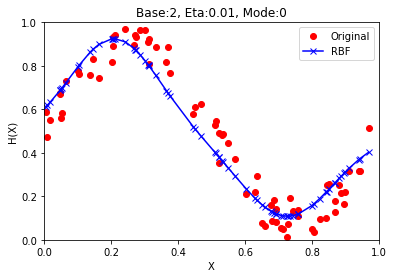

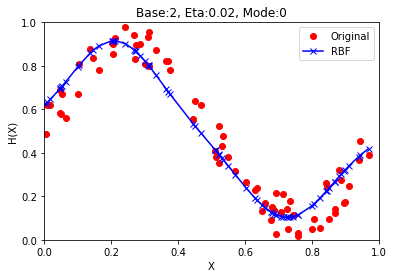

In [6]:
K = 2 # Number of bases/clusters

ETA = 0.01 # Learning rate
run(x,K,ETA,MODE,NUM_SAMPLES,NUM_EPOCHES)

ETA = 0.02 # Learning rate
run(x,K,ETA,MODE,NUM_SAMPLES,NUM_EPOCHES)


plt.show()


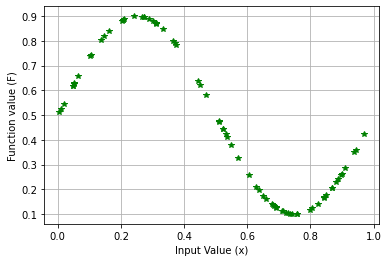

In [7]:
plt.plot(sample_x_list,sample_d_list,'g*')
plt.xlabel('Input Value (x)')
plt.ylabel('Function value (F)')
plt.grid()
plt.show()

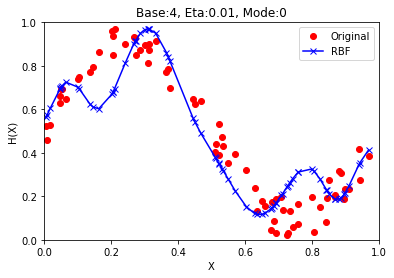

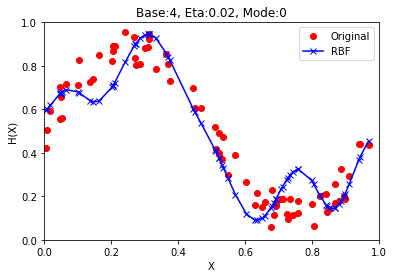

In [8]:
K = 4 # Number of bases/clusters

ETA = 0.01 # Learning rate
run(x,K,ETA,MODE,NUM_SAMPLES,NUM_EPOCHES)

ETA = 0.02 # Learning rate
run(x,K,ETA,MODE,NUM_SAMPLES,NUM_EPOCHES)

plt.show()


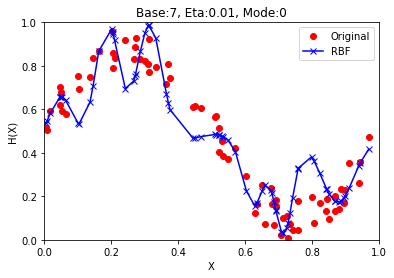

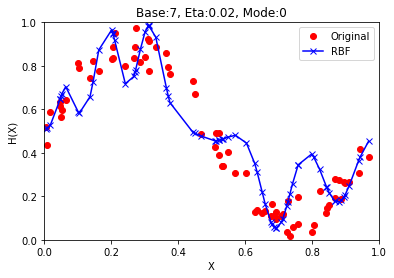

In [9]:
K = 7 # Number of bases/clusters

ETA = 0.01 # Learning rate
run(x,K,ETA,MODE,NUM_SAMPLES,NUM_EPOCHES)

ETA = 0.02 # Learning rate
run(x,K,ETA,MODE,NUM_SAMPLES,NUM_EPOCHES)

plt.show()


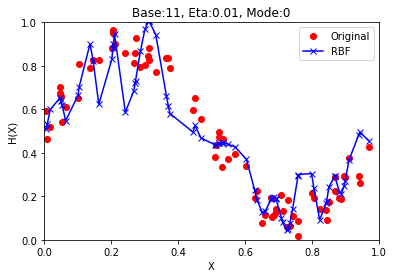

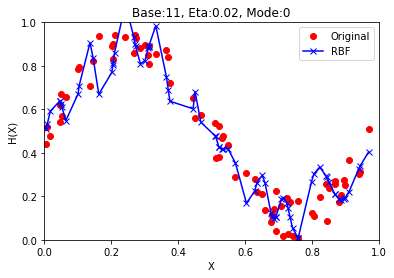

In [10]:
K = 11 # Number of bases/clusters

ETA = 0.01 # Learning rate
run(x,K,ETA,MODE,NUM_SAMPLES,NUM_EPOCHES)

ETA = 0.02 # Learning rate
run(x,K,ETA,MODE,NUM_SAMPLES,NUM_EPOCHES)

plt.show()


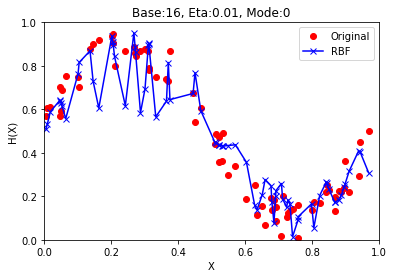

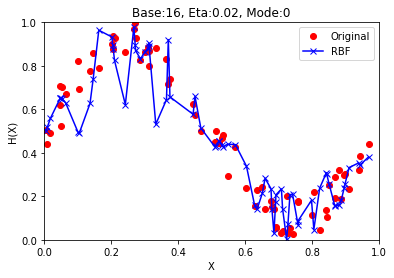

In [11]:
K = 16 # Number of bases/clusters

ETA = 0.01 # Learning rate
run(x,K,ETA,MODE,NUM_SAMPLES,NUM_EPOCHES)

ETA = 0.02 # Learning rate
run(x,K,ETA,MODE,NUM_SAMPLES,NUM_EPOCHES)

plt.show()


### Plot graphs for different cluster sizes (K=2, 4, 7, 11, 16), with universal variances, and learning rates (0.01, 0.02)

In [12]:
MODE = 1  # Universal variance

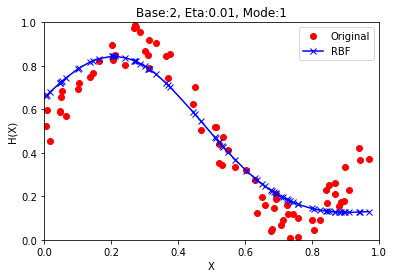

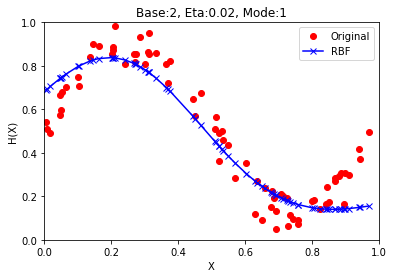

In [13]:
K = 2 # Number of bases/clusters

ETA = 0.01 # Learning rate
run(x,K,ETA,MODE,NUM_SAMPLES,NUM_EPOCHES)

ETA = 0.02 # Learning rate
run(x,K,ETA,MODE,NUM_SAMPLES,NUM_EPOCHES)

plt.show()


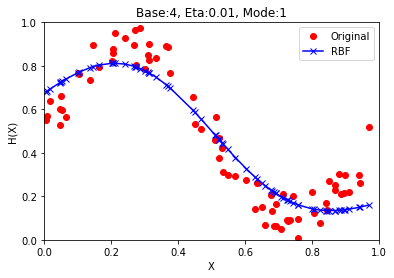

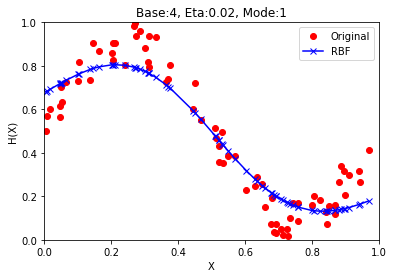

In [14]:
K = 4 # Number of bases/clusters

ETA = 0.01 # Learning rate
run(x,K,ETA,MODE,NUM_SAMPLES,NUM_EPOCHES)

ETA = 0.02 # Learning rate
run(x,K,ETA,MODE,NUM_SAMPLES,NUM_EPOCHES)

plt.show()


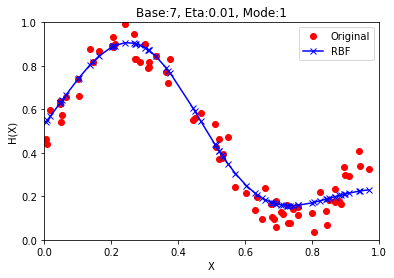

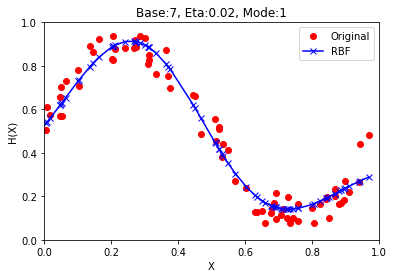

In [15]:
K = 7 # Number of bases/clusters

ETA = 0.01 # Learning rate
run(x,K,ETA,MODE,NUM_SAMPLES,NUM_EPOCHES)

ETA = 0.02 # Learning rate
run(x,K,ETA,MODE,NUM_SAMPLES,NUM_EPOCHES)

plt.show()


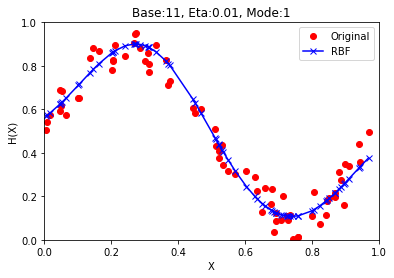

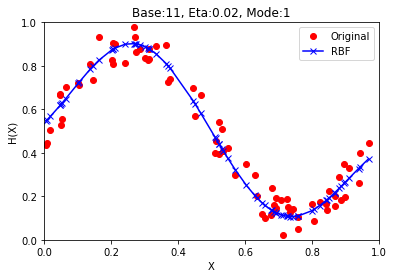

In [16]:
K = 11 # Number of bases/clusters

ETA = 0.01 # Learning rate
run(x,K,ETA,MODE,NUM_SAMPLES,NUM_EPOCHES)

ETA = 0.02 # Learning rate
run(x,K,ETA,MODE,NUM_SAMPLES,NUM_EPOCHES)

plt.show()


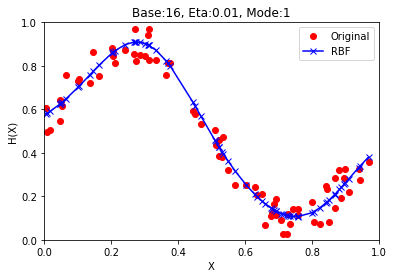

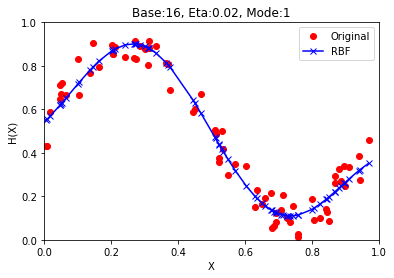

In [17]:
K = 16 # Number of bases/clusters

ETA = 0.01 # Learning rate
run(x,K,ETA,MODE,NUM_SAMPLES,NUM_EPOCHES)

ETA = 0.02 # Learning rate
run(x,K,ETA,MODE,NUM_SAMPLES,NUM_EPOCHES)

plt.show()
